# <u> Ocular Cataract Intelligent Recognition (OCIR) </u>

<i>Leveraging the power of Deep Learning, our trained Convolutional Neural Network(CNN) model aims to detect one of the most common ocular conditions- Cataract.</i>

<u><i>Project Team:</i></u>
1. Joshua S Raju 22BAI1213
2. Shubham Yadav 22BAI1427
3. Md Rameez Haider 22BRS1327
   

<b><u>DISCLAIMER:</b></u> <i>While our CNN model aids in cataract detection, it is not a substitute for professional medical advice. Please consult a qualified healthcare provider for a comprehensive eye examination and diagnosis.</i>


<b>DATASET:</b>
https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
https://www.kaggle.com/datasets/jr2ngb/cataractdataset

## Importing Dependencies

In [1]:
import numpy as np
import os

import cv2
import matplotlib.pylab as plt
import imghdr

import tensorflow as tf

Tensorflow GPU Management 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Cleaning Image Data

In [3]:
data_dir = 'imgdata_v3'

img_exts = ['jpeg', 'jpg', 'png']
img_exts

# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        img_path = os.path.join(data_dir, image_class,image)
        img = plt.imread(img_path)
        ext = imghdr.what(img_path)
        try:
            if ext not in img_exts:
                os.remove(img_path)
                print('{} successfully removed'.format(img_path))
        except Error as e :
                print('Issue with {}'.format(img_path))

## Image Enhancement Functions

 <i>Crop Function</i>

In [ ]:
lower = np.array([0,0,0])
higher = np.array([30,30,30])

def crop(image):
    img_copy = image.copy()
    mask  = cv2.inRange(image, lower, higher)
    inverted_mask = cv2.bitwise_not(mask)

    cont,_ = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(image, cont, -1, 255, 10)

    c = max(cont, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    img_cropped = img_copy[y:y+h, x:x+w]

    print('{} successfully cropped'.format(img_path))
    
    return img_cropped

<i>Contour Detection Function</i>

In [ ]:
lower = np.array([0,0,0])
higher = np.array([30,30,30])

def contour(image):
    mask  = cv2.inRange(image, lower, higher)
    inverted_mask = cv2.bitwise_not(mask)
    cont,_ = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    return len(cont)

<i> Sharpening Function </i>

In [ ]:
kernel_sharpen = np.array([[-1,-1,-1],
                          [-1,9,-1],
                          [-1,-1,-1]])

def sharpen(image):
    img_sharpen = cv2.filter2D(image, -1, kernel_sharpen)

    return img_sharpen

<i> Save Function </i>

def save(path, image):
    plt.imsave(path, image)

### PreProcessing Image

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        img_path = os.path.join(data_dir, image_class,image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if img[0][0][0] == 255:
            os.remove(img_path)
            print('{} White-background image successfully removed'.format(img_path))
        elif img.shape[0] != img.shape[1]:
            img_crop = crop(img)
            img_resize = cv2.resize(img_crop, (512,512))
            img_sharpen = sharpen(img_resize)
            save(img_path, img_sharpen)
        # elif contour(img)>1:
        #     os.remove(img_path)
        #     print('{} Non-transformable image removed'.format(img_path))
        else:
            img_resize = cv2.resize(img, (512,512))
            img_sharpen = sharpen(img_resize)
            save(img_path, img_sharpen)  

## Data Augmentation

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(brightness_range=(0.1, 1.5),
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        img_path = os.path.join(data_dir, image_class,image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_reshaped = img.reshape((1,)+img.shape)
        
        i=0
        for batch in datagen.flow(img_reshaped,
                                 batch_size=1,
                                 save_to_dir=os.path.join(data_dir, image_class),
                                 save_prefix='DA',
                                 save_format='jpg'):
            i+=1
            if i>2:
                break

## Creating Image Dataset

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256, 256))

Found 7437 files belonging to 2 classes.


In [5]:
batch = dataset.as_numpy_iterator().next()
len(batch)

2

In [6]:
classes = ['cataract', 'normal']
classes

['cataract', 'normal']

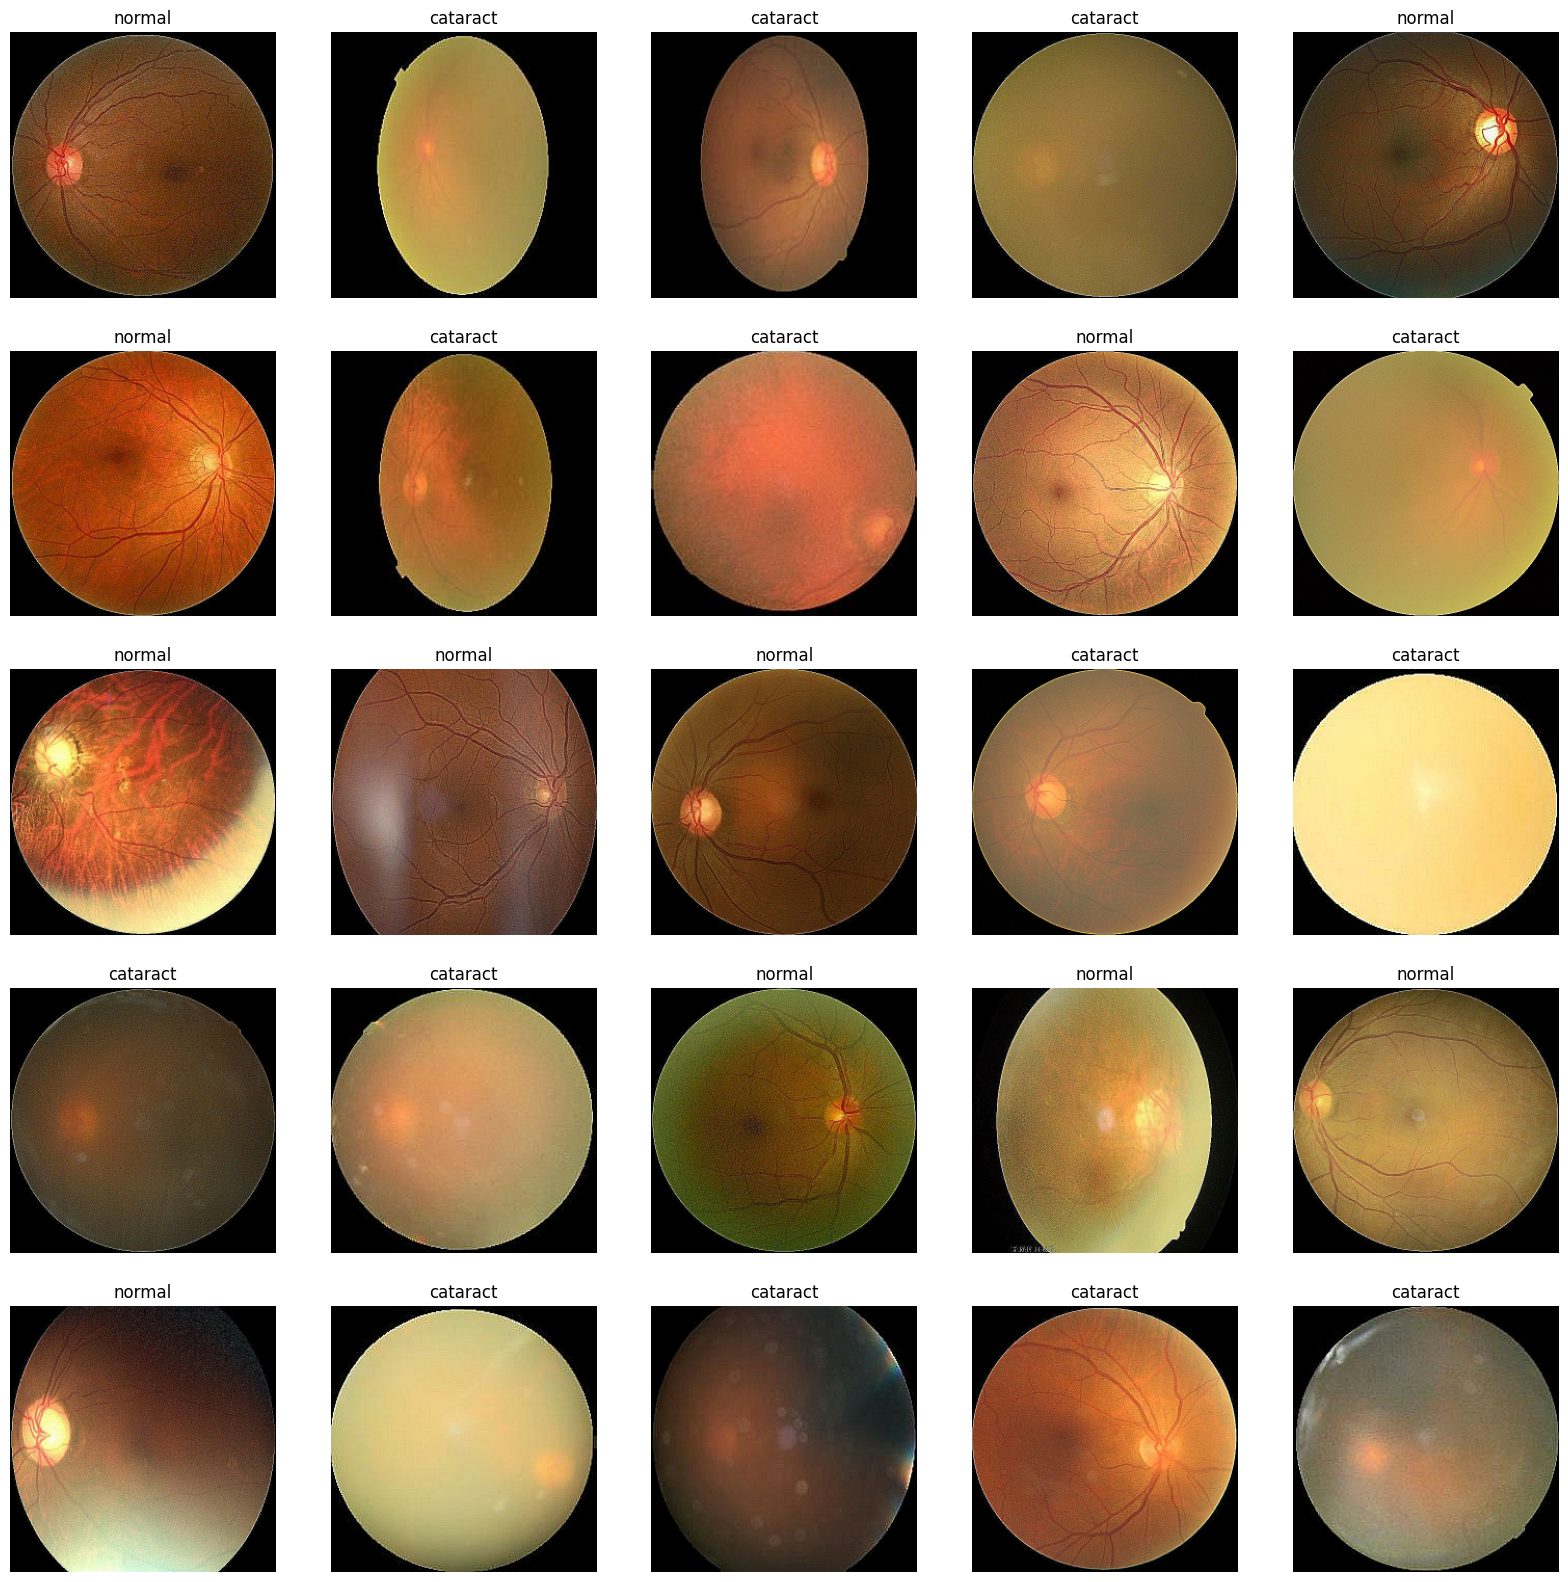

In [7]:
fig, axs = plt.subplots(5,5, figsize=(20,20))
for idx, img in enumerate(batch[0][:25]):
    row = idx//5
    col = idx%5

    axs[row, col].imshow(img.astype(int))
    axs[row, col].axis('off')
    axs[row, col].set_title(classes[batch[1][idx]])

## Scaling Dataset

In [8]:
batch[0][0].shape, batch[0][0].max(), batch[0][0].min()

((256, 256, 3), 255.0, 0.0)

In [9]:
data = dataset.map(lambda x,y: (x/255, y))

In [10]:
print(data.as_numpy_iterator().next()[0][0].shape, 
    data.as_numpy_iterator().next()[0][0].max(), 
    data.as_numpy_iterator().next()[0][0].min())

(256, 256, 3) 1.0 0.0


## Splitting Dataset

In [11]:
len(data)

233

In [12]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.1)

train_size + val_size + test_size

233

In [13]:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

## Training CNN Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

In [15]:
logdir = 'LogDir'

try:
    os.mkdir(logdir)
except Exception as e:
    pass    

tfb_callback = tf.keras.callbacks.TensorBoard(logdir)

In [16]:
model_fit = model.fit(train_data, 
                      epochs=30, 
                      shuffle=True, 
                      validation_data=val_data, 
                      callbacks=[tfb_callback])

Epoch 1/30
163/163 [==============================] - 24s 73ms/step - loss: 0.5947 - accuracy: 0.6984 - val_loss: 0.6156 - val_accuracy: 0.6549
Epoch 2/30
163/163 [==============================] - 9s 52ms/step - loss: 0.3496 - accuracy: 0.8616 - val_loss: 0.4210 - val_accuracy: 0.8444
Epoch 3/30
163/163 [==============================] - 8s 51ms/step - loss: 0.3051 - accuracy: 0.8815 - val_loss: 0.3787 - val_accuracy: 0.8916
Epoch 4/30
163/163 [==============================] - 9s 53ms/step - loss: 0.2434 - accuracy: 0.9015 - val_loss: 0.3014 - val_accuracy: 0.8956
Epoch 5/30
163/163 [==============================] - 8s 51ms/step - loss: 0.2206 - accuracy: 0.9030 - val_loss: 0.2479 - val_accuracy: 0.9009
Epoch 6/30
163/163 [==============================] - 8s 51ms/step - loss: 0.2156 - accuracy: 0.9024 - val_loss: 0.2977 - val_accuracy: 0.8870
Epoch 7/30
163/163 [==============================] - 8s 50ms/step - loss: 0.1904 - accuracy: 0.9135 - val_loss: 0.2501 - val_accuracy: 0.920

## Model Performance 

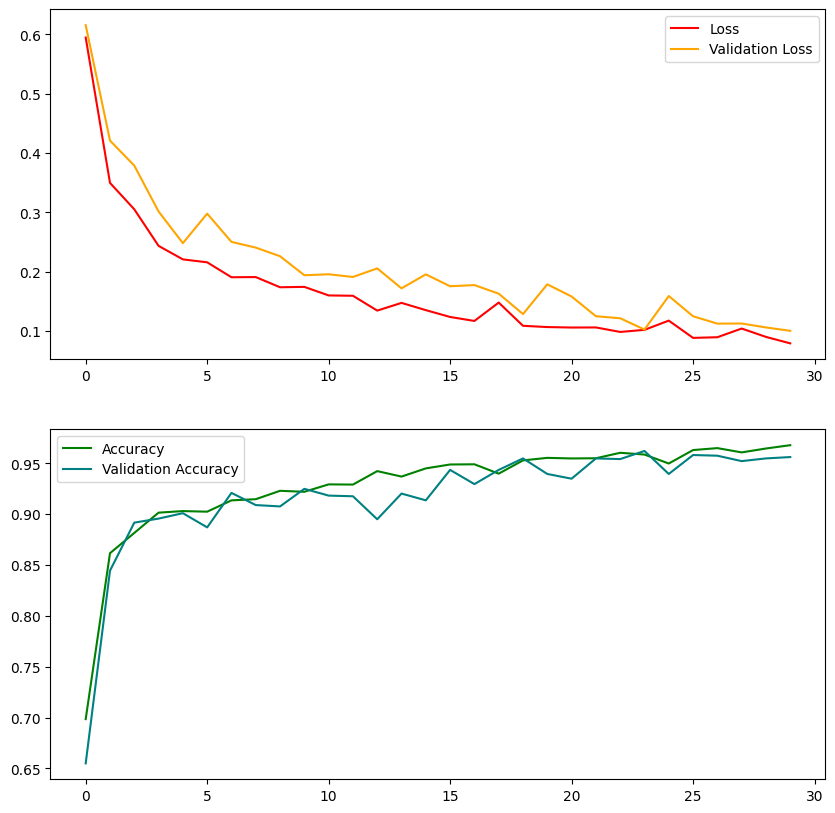

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(model_fit.history['loss'], color='red', label='Loss')
axs[0].plot(model_fit.history['val_loss'], color='orange', label='Validation Loss')
axs[0].legend(loc='upper right')

axs[1].plot(model_fit.history['accuracy'], 
             color='green', 
             label='Accuracy')
axs[1].plot(model_fit.history['val_accuracy'], 
             color='teal', 
             label='Validation Accuracy')
axs[1].legend(loc='upper left')

## Evaluating Model

In [20]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity

pre = Precision()
acc = BinaryAccuracy()
rec = Recall()
spe = SpecificityAtSensitivity(0.5)

In [21]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)
    acc.update_state(y, y_pred)
    spe.update_state(y, y_pred)

1/1 [==============================] - 0s 247ms/step


In [22]:
precision = pre.result().numpy()
recall = rec.result().numpy()
f1 = 2 * (precision*recall) / (precision+recall)

print('Accuracy\t:', acc.result().numpy())
print('Precision\t:', precision)
print('Recall\t\t:', recall)
print('Specificity\t:', spe.result().numpy())
print('F1\t\t:', f1)

Accuracy	: 0.9400279
Precision	: 0.96275073
Recall		: 0.91803277
Specificity	: 1.0
F1		: 0.9398601370234281


## Exporting Model

In [23]:
model.save(os.path.join('models', 'ODIR_CNN.h5'))

In [24]:
from tensorflow.keras.models import load_model

model = load_model(os.path.join('models', 'ODIR_CNN.h5'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0